In [1]:
import os
from statistics import mean, median, stdev
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path_corrected_proto2='/data/aq/nyserda/proto2/corrected/bad_rows_removed_5min/'

proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)

In [3]:
proto2_columns = proto2_corrected.columns
proto2_columns.drop(['date','datetimestamp', 'unix_time']);

20220303.csv
Analyzing...  pm25_env_ugm3
Analyzing...  pres_bmp388_hPa
Analyzing...  temp_sht31_degC
Analyzing...  rh_sht31_percent
Analyzing...  O3NO2_V
Analyzing...  CO_V
Analyzing...  NO_V
Analyzing...  NO2_V
Analyzing...  O3NO2_aux_V
Analyzing...  CO_aux_V
Analyzing...  NO_aux_V
Analyzing...  NO2_aux_V
Analyzing...  TVOC_V
20210706.csv
Analyzing...  pm25_env_ugm3
Analyzing...  pres_bmp388_hPa
Analyzing...  temp_sht31_degC
Analyzing...  rh_sht31_percent
Analyzing...  O3NO2_V
Analyzing...  CO_V
Analyzing...  NO_V
Analyzing...  NO2_V
Analyzing...  O3NO2_aux_V
Analyzing...  CO_aux_V
Analyzing...  NO_aux_V
Analyzing...  NO2_aux_V
Analyzing...  TVOC_V
20220523.csv
Analyzing...  pm25_env_ugm3
Analyzing...  pres_bmp388_hPa
Analyzing...  temp_sht31_degC
Analyzing...  rh_sht31_percent
Analyzing...  O3NO2_V
Analyzing...  CO_V
Analyzing...  NO_V
Analyzing...  NO2_V
Analyzing...  O3NO2_aux_V
Analyzing...  CO_aux_V
Analyzing...  NO_aux_V
Analyzing...  NO2_aux_V
Analyzing...  TVOC_V
20220211.csv


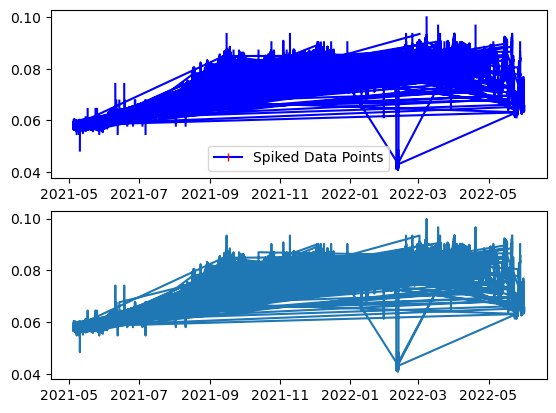

Processed 392 files.


In [13]:
path = 'corrected-Sept-Modified/' #Ensure double slashes are present at end of string for Python to parse correctly
path='/data/aq/nyserda/proto2/corrected/bad_rows_removed_5min/'

pathToSaveTo = "/scripts/full_despiked_proto2/" #Enter output directory you wish to save the processed files to

directoryOfFile = os.listdir(path)
numFiles = len(directoryOfFile)
runningTotal=0

columns = proto2_columns
columns = ['pm25_env_ugm3', 'pres_bmp388_hPa', 'temp_sht31_degC',
           'rh_sht31_percent', 'O3NO2_V', 'CO_V', 'NO_V', 'NO2_V', 'O3NO2_aux_V',
           'CO_aux_V', 'NO_aux_V', 'NO2_aux_V','TVOC_V']

index=0
for h in directoryOfFile:
    #df = pd.read_csv(path+h,skiprows=[0,2],on_bad_lines='skip',encoding="utf-8",index_col=False)
    df = pd.read_csv(path+h,on_bad_lines='skip',encoding="utf-8",index_col=False)

    #print(df.head)

    print(h)

    #Omit negligent headers:
    #df = df[df.pm25_env_ugm3 != 'pm25_env_ugm3'] 
    #df = df[df.datetimestamp != '6B7AC8BB5339463533202020FF62026']
    #df = df[df.datetimestamp != 'YYYYMMDDTHHMMSS']

    df['datetimestamp'] = pd.to_datetime(df['datetimestamp'])

    df.reset_index(drop=True, inplace=True)

    # filtering out the rows with `POSITION_T` value in corresponding column
    #print(df.datetimestamp)

    #Static variables here
    thresholdHigh = 500 #Enter threshold for high here
    thresholdLow = 0 #Enter low threshold here
    nstds = 1 #Enter deviance from std -- a default value of 1 equals 100% of std
    #columnToAnalyze = 'pm25_env_ugm3' #Enter variable to analyze
    
    for column in columns: 
        print('Analyzing... ', column)
        columnToAnalyze = column #Enter variable to analyze #<---
    #columnToAnalyze = 'pm25_env' #Enter variable to analyze

    df[columnToAnalyze] = pd.to_numeric(df[columnToAnalyze]) #<---
    #df["pm25_env"] = pd.to_numeric(df["pm25_env"])

    minPrior = min(df[columnToAnalyze])
    maxPrior = max(df[columnToAnalyze])
    medianPrior = median(df[columnToAnalyze])
    meanPrior = mean(df[columnToAnalyze])
    stdPrior = stdev(df[columnToAnalyze])
    stdevRange = 2

    if (index == 0): #Set initial dataframe to first prior to despike DF
        dataFrameConcatPrior=df
    else: #Now, after every iteration concatenate to form one big one DF
        dataFrameConcatPrior = pd.concat([dataFrameConcatPrior, df], ignore_index=True)

    nullVals = df[columnToAnalyze].isnull() #Get logical columns if NaN values are present
    isLowerThanThreshold = df[columnToAnalyze] < thresholdLow
    isGreaterThanThreshold = df[columnToAnalyze] > thresholdHigh

    spikedVals = nullVals | isLowerThanThreshold | isGreaterThanThreshold

    markers_on = [i for i, x in enumerate(spikedVals) if x]

    if (index == 0): #Set initial list 
        markers_on_total=markers_on
    else: #Now, after every iteration concatenate to form one big one
        #print(markers_on)
        new_list = [x+runningTotal for x in markers_on]
        markers_on_total = markers_on_total+new_list
        #markers_on_total.extend(markers_on)

    runningTotal=runningTotal+len(df)

    dataPostSpiked = df.drop(labels=markers_on, axis=0,inplace=False) #Delete rows of spiked data

    stdPost = stdev(dataPostSpiked[columnToAnalyze])
    minPost = min(dataPostSpiked[columnToAnalyze])
    maxPost = max(dataPostSpiked[columnToAnalyze])
    medianPost = median(dataPostSpiked[columnToAnalyze])
    meanPost = mean(dataPostSpiked[columnToAnalyze])

    outsideOfStdev1 = dataPostSpiked[columnToAnalyze] > stdPost 
    outsideOfStdev2 = dataPostSpiked[columnToAnalyze] < -stdPost
    outsideOfStdev = outsideOfStdev1 | outsideOfStdev2

    #markers_on = [i for i, x in enumerate(outsideOfStdev) if x]
    stdPost = stdev(dataPostSpiked[columnToAnalyze])

    data = [['Min',minPrior,minPost],['Max',maxPrior,maxPost],['Median',medianPrior,medianPost],['Mean',meanPrior,meanPost],['Std',stdPrior,stdPost]] #For stats dataframe
    
    # Create the DataFrame with statistical data
    toCSVdf = pd.DataFrame(data, columns=['Variable','Pre-Processing', 'Post-Processing'])
    #toCSVdf.to_csv(pathToSaveTo+h[1:11]+'stats.csv',index=False)

    #Save new CSV file
    #dataPostSpiked.to_csv(pathToSaveTo+h[1:11]+'.csv',index=False)

    if (index == 0): #Set initial dataframe to first despiked DF
            dataFrameConcatPost=dataPostSpiked
    else: #Now, after every iteration concatenate to form one big one
        dataFrameConcatPost = pd.concat([dataFrameConcatPost, dataPostSpiked], ignore_index=True)
        
    index=index+1

#print(dataFrameConcat)

figure, axis = plt.subplots(2, 1)

#print(markers_on_total)
axis[0].plot(dataFrameConcatPrior['datetimestamp'],dataFrameConcatPrior[columnToAnalyze], '-b|', markevery=markers_on_total, label='Spiked Data Points',markeredgecolor=('r'))
axis[0].legend()
#plot.title("Pre-Processing Spikes")
axis[1].plot(dataFrameConcatPost['datetimestamp'],dataFrameConcatPost[columnToAnalyze]) #Plot data after spike processing
#axis[1].title("Post-Processed Data")

plt.show()

print("Processed " +str(numFiles)+ " files.")

In [16]:
dataFrameConcatPost

,date,datetimestamp,unix_time,temp_bmp388_degC,pres_bmp388_hPa,temp_sht31_degC,rh_sht31_percent,O3NO2_V,CO_V,NO_V,...,pm100_std_ugm3,pm10_env_ugm3,pm25_env_ugm3,pm100_env_ugm3,particles_03um,particles_05um,particles_10um,particles_25um,particles_50um,particles_100um
0,2022-03-03 00:00:00,2022-03-03 00:02:29.644067840,1.646266e+09,8.427627,1011.536441,7.693559,64.060169,0.249225,0.408704,0.293615,...,70.677966,30.830508,48.915254,59.661017,7652.745763,2097.847458,437.745763,33.338983,3.000000,0.932203
1,2022-03-03 00:05:00,2022-03-03 00:07:28.883333376,1.646266e+09,8.325667,1011.512333,7.615500,64.785833,0.249456,0.418325,0.292734,...,74.116667,31.883333,49.800000,61.366667,7931.450000,2201.883333,455.250000,35.000000,3.883333,1.400000
2,2022-03-03 00:10:00,2022-03-03 00:12:28.728813568,1.646266e+09,8.247288,1011.505085,7.551525,65.526271,0.249707,0.425076,0.294034,...,80.525424,33.610169,53.084746,64.254237,8696.389831,2414.966102,491.627119,37.966102,4.779661,1.101695
3,2022-03-03 00:15:00,2022-03-03 00:17:27.406779648,1.646267e+09,8.175763,1011.634407,7.495763,66.102373,0.249332,0.430169,0.293275,...,73.203390,31.406780,49.406780,60.983051,7829.796610,2136.525424,458.644068,35.135593,4.220339,1.440678
4,2022-03-03 00:20:00,2022-03-03 00:22:27.610169088,1.646267e+09,8.116780,1011.543729,7.455593,67.000169,0.250119,0.404636,0.293700,...,76.762712,32.440678,50.898305,62.796610,8342.135593,2287.796610,487.576271,36.152542,4.050847,0.932203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109326,2022-04-26 23:35:00,2022-04-26 23:37:24.603448320,1.651016e+09,16.500690,1011.121552,15.736379,78.726379,0.242613,0.554045,0.297964,...,23.913793,13.931034,22.879310,23.913793,2761.396552,748.896552,150.500000,10.689655,1.310345,0.224138
109327,2022-04-26 23:40:00,2022-04-26 23:42:25.448275712,1.651017e+09,16.422414,1011.206207,15.699138,78.793103,0.242112,0.508384,0.297281,...,22.224138,13.448276,21.655172,22.224138,2616.931034,708.120690,147.793103,9.086207,0.879310,0.155172
109328,2022-04-26 23:45:00,2022-04-26 23:47:25.298245376,1.651017e+09,16.375088,1011.052982,15.677193,78.976667,0.242062,0.511943,0.297343,...,23.719298,13.210526,23.035088,23.719298,2593.684211,705.982456,159.947368,12.333333,0.859649,0.491228
109329,2022-04-26 23:50:00,2022-04-26 23:52:24.192982528,1.651017e+09,16.347018,1011.166667,15.662982,79.486667,0.241809,0.514983,0.299226,...,23.877193,13.701754,23.000000,23.877193,2670.315789,730.894737,161.982456,11.508772,1.333333,0.210526


In [18]:
dataFrameConcatPost.to_csv('proto2_despiked_extended.csv')

In [53]:
post_despike = dataFrameConcatPost['particles_25um'].max()
dataFrameConcatPost.columns

Index(['date', 'datetimestamp', 'unix_time', 'temp_bmp388_degC',
       'pres_bmp388_hPa', 'temp_sht31_degC', 'rh_sht31_percent', 'O3NO2_V',
       'CO_V', 'NO_V', 'NO2_V', 'O3NO2_aux_V', 'CO_aux_V', 'NO_aux_V',
       'NO2_aux_V', 'O3NO2_ppb', 'CO_ppb', 'NO_ppb', 'NO2_ppb', 'TVOC_V',
       'TVOC_ppb', 'pm10_std_ugm3', 'pm25_std_ugm3', 'pm100_std_ugm3',
       'pm10_env_ugm3', 'pm25_env_ugm3', 'pm100_env_ugm3', 'particles_03um',
       'particles_05um', 'particles_10um', 'particles_25um', 'particles_50um',
       'particles_100um'],
      dtype='object')

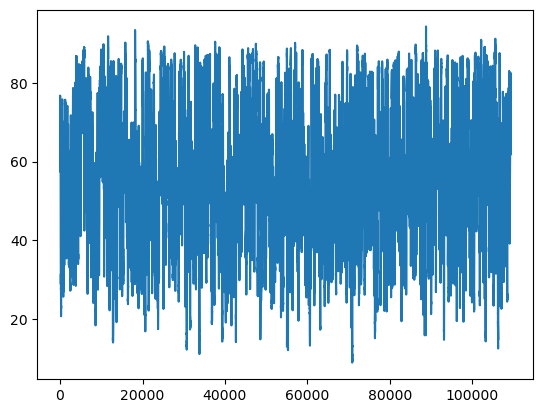

In [67]:
plt.plot(dataFrameConcatPost['rh_sht31_percent'])